 # Predicting future customer behaviors at Beta Bank

Beta Bank is noticing that some of their customers are leaving the bank. Instead of using a lot of effort and energy to replace these customers, it is more cost efficient to attempt to keep these customers from leaving. Beta Bank has requested analysis and modeling to help predict which customers may leave, so they can get ahead of trying to retain these customers as well identify  patterns into the behaviors of which customers are more likely leave. Using behavior and contract data provided by the bank, several models were created and analyzed performance and prediction ability. The threshold for an accurate model is a F1 score of <b>59%</b>.

## Initialization

In [1]:
# Load all libraries and modules
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from collections import defaultdict
from functools import partial

## Load data

In [2]:
# Load data into a pandas DataFrame
data = pd.read_csv('/datasets/Churn.csv')

## Data overview

The bulleted list below provides detailed explanations on the data provided from the csv file and also denotes which columns are potential features for the predictive model and what column is the target, ie what the model will be attempting to predict. The data provides insight into customer's banking habits, personal information, and how the services provided by Beta Bank are used.

Potential Features

- <b>RowNumber</b> — data string index
- <b>CustomerId</b> — unique customer identifier
- <b>Surname</b> — surname
- <b>CreditScore</b> — credit score
- <b>Geography</b> — country of residence
- <b>Gender</b> — gender
- <b>Age</b> — age
- <b>Tenure</b> — period of maturation for a customer’s fixed deposit (years)
- <b>Balance</b> — account balance
- <b>NumOfProducts</b> — number of banking products used by the customer
- <b>HasCrCard</b> — customer has a credit card
- <b>IsActiveMember</b> — customer’s activeness
- <b>EstimatedSalary</b> — estimated salary

Target

- <b>Exited</b> — сustomer has left

Below, a more thorough dive into the data provides a deeper overview. A general summary of the DataFrame and some extended analysis on certain features / columns adds more insight into what data the model will be working with.

### General summary

There are 14 columns within the dataset with a total of 10000 records, so we have information on 10000 customers at Beta Bank. 3 fields are of an object data type, 8 are integer, and 3 are float. Some general observations about the columns:

- <mark><b>RowNumber</b></mark> is nonessential data. It doesn't provide any information about the customer
- <mark><b>CustomerId</b></mark> and <mark><b>Surname</b></mark> do provide information about the customer, but this data might not be irrelevant for predictive modeling purposes
- <mark><b>Tenure</b></mark> has missing values in some of the records. We'll explore this later. It also is an integer data type which may not be necessary
- <mark><b>Exited</b></mark> as displayed above is the <b>Target</b>. This is what the model will try to predict
- The remaining fields provide good information about the customer's banking habits or personal information

In [3]:
# General summary of the DataFrame
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Extended analysis

Additional analysis was performed on certain fields to get a better understanding on some of the data specifics. First, value ranges were gathered for the following fields:

- <mark><b>Tenure</b></mark> - 0 - 10 years
  - Tenure represents how long, or the *term*, that money must stay in an account before you can take it out to avoid interest penalities or fees. Customers with a higher term may not want to leave the bank or remove their account because of these interest penalities 
- <mark><b>NumofProducts</b></mark> - 1 - 4 products
  - The highest number of products a customer uses is 4. This does not conclude that Beta Bank only provides a total of 4 products, but I assume the total products offered is not far away from 4, if it is not 4
- <mark><b>Balance</b></mark> - 0 - 250898.09 dollars
- <mark><b>EstimatedSalary</b></mark> - 0 - 199998.48 dollars

Preliminary deduction on certain traits and characteristics were also performed to see if there was any connection between these traits and members that exited. The predictive model will do this type of analysis for us later in the report, but this does provide an initial look into what data for certain fields might affect the probability of a customer leaving.

- <mark><b>Age</b></mark> - The ages representing the least amount of exit members are to some extent sporadic. There are old ages and young ages within the top 15 that have exited Beta Bank. There doesn't seem to be a correlation. However, ages representing the largest amount of exit members interestingly are all in the 40s and a few in the 50s
- <mark><b>Balance</b></mark> - The account balances representing the least amount of exit members are sporadic. There is no clear correlation. For balances representing the largest amount of exit members, there is perhaps a small relation between balance amount and if the customer exited, but stating there is a correlation is a stretch. An important observation however, is that customers with a balance of <b>0</b> dwarf all other balance values, perhaps indicating that customers that don't use their account eventually leave the bank
- <mark><b>EstimatedSalary</b></mark> The salaries of exit members are sporadic. There is no clear correlation in the data providing a pattern or insight to what salaries of members may be linked to leaving the bank
- <mark><b>Tenure</b></mark> - The tenures of the account did not show any correlation for the least amount of exit members nor largest amount. Interestingly however, the tenure of 0 had the least amount of exit members. A tenure of 0 means that a customer is not obiligated to leave their money in the account for a period of time. There is flexibility. It was originally thought that a tenure of 0 would represent the largest amount of exit members because there are no constaints to exiting. This is not the case. The other years all contain roughly the same amount of exit members, so there is no clear cause-and-effect with this data

Moreover, attempting to find clear correlations, relations, and weights in the data is sometimes difficult. Good thing we can create a machine learning model to assist us!

In [4]:
# Retrieve range of values for certain features
# Tenure
print('TENURE value range')
print()
print(data['Tenure'].min(), '-', data['Tenure'].max(), 'years')
print()
print()

# NumofProducts
print('NUMOFPRODUCTS value range')
print()
print(data['NumOfProducts'].min(), '-', data['NumOfProducts'].max(), 'products')
print()
print()

# Balance
print('BALANCE value range')
print()
print(data['Balance'].min(), '-', data['Balance'].max(), 'dollars')
print()
print()

#EstiamtedSalary
print('ESTIMATEDSALARY value range')
print()
print(data['EstimatedSalary'].min(), '-', data['EstimatedSalary'].max(), 'dollars')

TENURE value range

0.0 - 10.0 years


NUMOFPRODUCTS value range

1 - 4 products


BALANCE value range

0.0 - 250898.09 dollars


ESTIMATEDSALARY value range

11.58 - 199992.48 dollars


AGE vs EXIT MEMBERS

AGE WITH THE LEAST EXIT MEMBERS


Age
84    1
19    1
73    1
72    1
74    1
69    2
18    2
20    2
21    3
70    4
67    5
25    6
23    6
68    6
66    7
Name: Age, dtype: int64


AGE WITH THE MOST EXIT MEMBERS


Age
38    63
52    64
51    66
41    69
50    71
39    72
44    73
49    75
47    77
42    77
48    80
45    87
43    88
40    89
46    91
Name: Age, dtype: int64

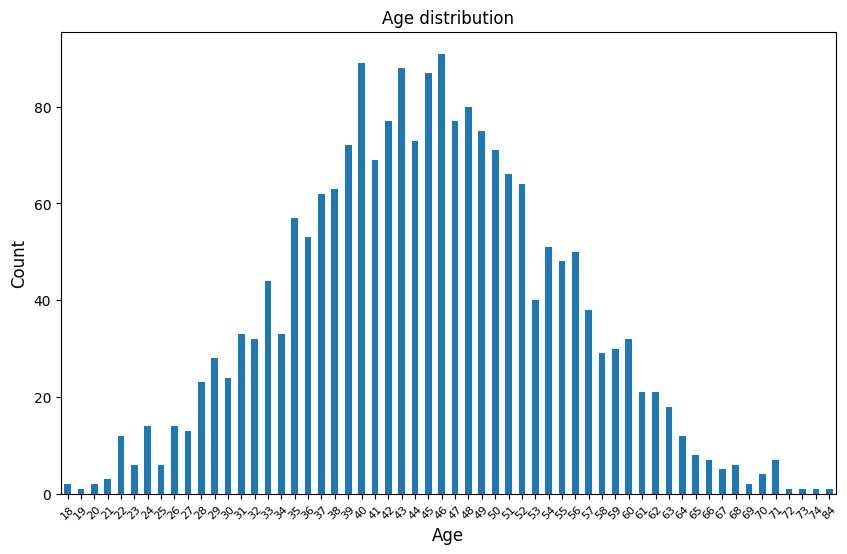

In [5]:
# Age of exit members review
# Filter for exit members
exit_members = data[data['Exited'] == 1]

# Group and sort by Age
print('AGE vs EXIT MEMBERS')
exit_age_group = exit_members.groupby('Age')['Age'].count()
print()
print('AGE WITH THE LEAST EXIT MEMBERS')
display(exit_age_group.sort_values().head(15))
print()
print('AGE WITH THE MOST EXIT MEMBERS')
display(exit_age_group.sort_values().tail(15))

# Create bar chart for age distribution
exit_age_group.plot(kind='bar', title='Age distribution', figsize=(10,6))
plt.ylabel('Count', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.xticks(rotation=45, fontsize=8)
plt.show()

BALANCE vs EXIT MEMBERS

BALANCE WITH THE LEAST EXIT MEMBERS


/tmp/ipykernel_50/2646699494.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_members['BalanceRounded'] = round(exit_members['Balance'], -4).astype(int)


BalanceRounded
250000     1
10000      1
240000     1
220000     2
20000      2
30000      4
210000     9
200000     9
40000     10
50000     14
190000    19
60000     27
180000    27
70000     42
170000    48
Name: BalanceRounded, dtype: int64


BALANCE WITH THE MOST EXIT MEMBERS


BalanceRounded
190000     19
60000      27
180000     27
70000      42
170000     48
160000     57
80000      58
90000      93
150000    110
100000    158
140000    159
130000    211
110000    230
120000    244
0         501
Name: BalanceRounded, dtype: int64

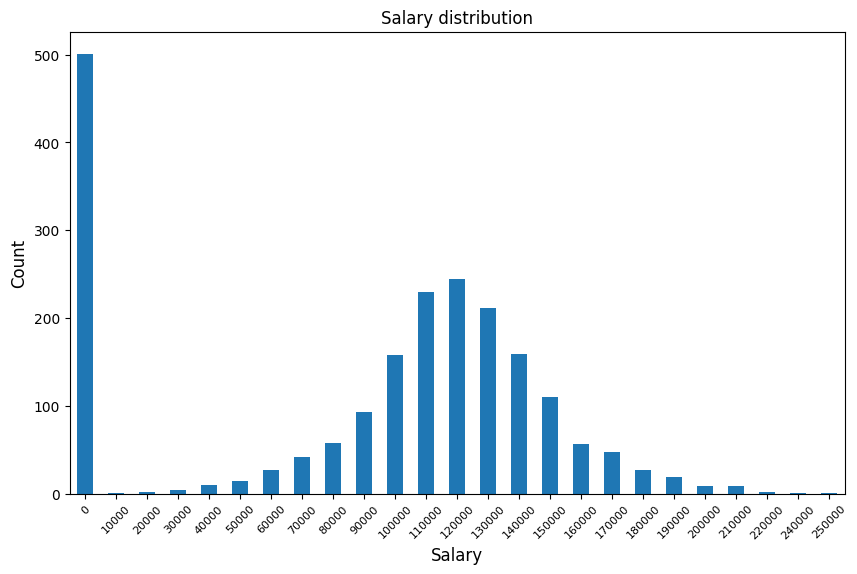

In [6]:
# Account balance of exit members review
# Create column rounding to the nearest 10000
exit_members['BalanceRounded'] = round(exit_members['Balance'], -4).astype(int)

# Group and sort by BalanceRounded
print('BALANCE vs EXIT MEMBERS')
exit_balance_group = exit_members.groupby('BalanceRounded')['BalanceRounded'].count()
print()
print('BALANCE WITH THE LEAST EXIT MEMBERS')
display(exit_balance_group.sort_values().head(15))
print()
print('BALANCE WITH THE MOST EXIT MEMBERS')
display(exit_balance_group.sort_values().tail(15))

# Create bar chart for balance distribution
exit_balance_group.plot(kind='bar', title='Salary distribution', figsize=(10,6))
plt.ylabel('Count', fontsize=12)
plt.xlabel('Salary', fontsize=12)
plt.xticks(rotation=45, fontsize=8)
plt.show()

BALANCE vs EXIT MEMBERS

BALANCE WITH THE LEAST EXIT MEMBERS


/tmp/ipykernel_50/2598604125.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_members['EstimatedSalaryRounded'] = round(exit_members['EstimatedSalary'], -4).astype(int)


EstimatedSalaryRounded
0          42
200000     42
80000      87
40000      87
100000     89
20000      92
150000     94
50000      98
110000    100
120000    104
130000    104
160000    104
60000     106
140000    106
170000    107
Name: EstimatedSalaryRounded, dtype: int64


BALANCE WITH THE MOST EXIT MEMBERS


EstimatedSalaryRounded
150000     94
50000      98
110000    100
120000    104
130000    104
160000    104
60000     106
140000    106
170000    107
10000     108
70000     109
190000    109
30000     113
90000     114
180000    122
Name: EstimatedSalaryRounded, dtype: int64

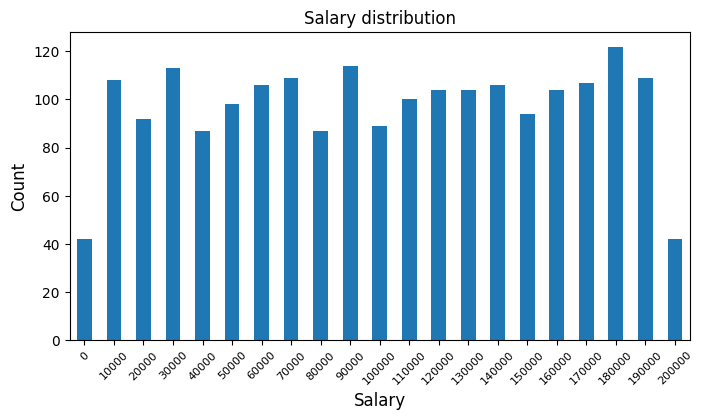

In [7]:
# Esimtated salary of exit members review
# Create column rounding to the nearest 10000
exit_members['EstimatedSalaryRounded'] = round(exit_members['EstimatedSalary'], -4).astype(int)

# Group and sort by BalanceRounded
print('BALANCE vs EXIT MEMBERS')
exit_salary_group = exit_members.groupby('EstimatedSalaryRounded')['EstimatedSalaryRounded'].count()
print()
print('BALANCE WITH THE LEAST EXIT MEMBERS')
display(exit_salary_group.sort_values().head(15))
print()
print('BALANCE WITH THE MOST EXIT MEMBERS')
display(exit_salary_group.sort_values().tail(15))

# Create bar chart for salary distribution
exit_salary_group.plot(kind='bar', title='Salary distribution', figsize=(8,4))
plt.ylabel('Count', fontsize=12)
plt.xlabel('Salary', fontsize=12)
plt.xticks(rotation=45, fontsize=8)
plt.show()

TENURE vs EXIT MEMBERS


Tenure
0.0      90
10.0     92
7.0     160
8.0     174
6.0     177
4.0     184
2.0     185
5.0     187
9.0     194
3.0     198
1.0     213
Name: Tenure, dtype: int64

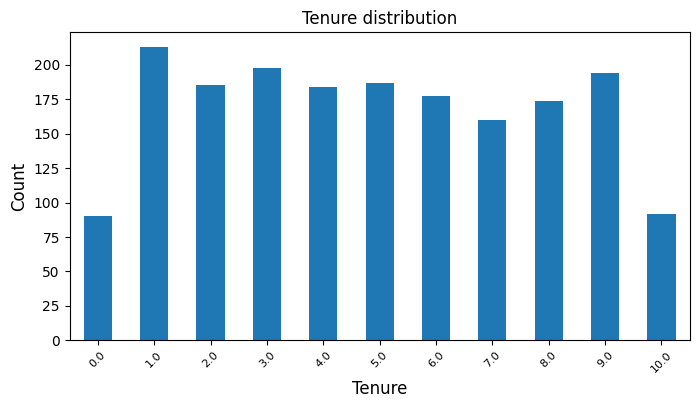

In [8]:
# Tenure of exit members review
# Group and sort by Tenure
print('TENURE vs EXIT MEMBERS')
exit_tenure_group = exit_members.groupby('Tenure')['Tenure'].count()
display(exit_tenure_group.sort_values())

# Create bar chart for tenure distribution
exit_tenure_group.plot(kind='bar', title='Tenure distribution', figsize=(8,4))
plt.ylabel('Count', fontsize=12)
plt.xlabel('Tenure', fontsize=12)
plt.xticks(rotation=45, fontsize=8)
plt.show()


## Data preparation

All the data types for the fields are correct. There could be an argument to convert the data type of the <mark><b>Tenure</b></mark> field from float to integer since there is no leading decimal information for any of the records. However, being float will not affect any future analysis or modeling, so it will be left as float.

There are no duplicate rows in the dataset nor duplicate <mark><b>CustomerId</b></mark> values. It needed to be confirmed that there were no duplicate customers in the dataset, so the same customer wasn't analyzed more than once. No duplicates, no clean-up needed here.

There are 909 missing values for the <mark><b>Tenure</b></mark> field. When looking at a small sample of records with missing <mark><b>Tenure</b></mark> values, there was no clear pattern identifying why there are missing values or what the cause may have been. However, removing the rows would be a substantial amount of the dataset, roughly 10%. Definitely do not want to do that as important information could be lost. So, the <font color='red'><b>median</b></font> of the <mark><b>Tenure</b></mark> field was gathered and the missing values were replaced with the mean (which was rounded to the nearest integer).

Lastly, it was determined that a few columns in the dataset were not going to be useful in predicting which customers will leave the bank or not because the columns didn't provide much useful information. These columns are <mark><b>RowNumber</b></mark>, <mark><b>CustomerId</b></mark>, and <mark><b>Surname</b></mark>. Therefore, the columns have been removed from the dataset so they wouldn't be a part of the features in the model.

### Duplicate values

In [9]:
# Check for duplicate rows and duplicate CustomerIds
print('Duplicate rows:', data.duplicated().sum())
print()
print('Duplicate CustomerIds:', data[data.duplicated(subset=['CustomerId'])])

Duplicate rows: 0

Duplicate CustomerIds: Empty DataFrame
Columns: [RowNumber, CustomerId, Surname, CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Exited]
Index: []


### Missing values

In [10]:
# Retrieve unique values for Tenure
display(data['Tenure'].unique())
print()

# Retrieve missing value counts and display a table output of the records
print('Total number of missing values for Tenure field:', data['Tenure'].isna().sum())
display(data[data['Tenure'].isna()].sample(15))


array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])


Total number of missing values for Tenure field: 909


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6954,6955,15799042,Zaytseva,611,France,Male,38,NaN,0.00,1,1,1,63202.00,0
7274,7275,15680901,Potter,652,France,Female,34,NaN,97435.85,2,1,1,104331.76,0
6655,6656,15703763,Sanderson,554,France,Male,44,NaN,85304.27,1,1,1,58076.52,0
2577,2578,15724145,William,616,Germany,Male,29,NaN,149318.55,1,1,0,140746.13,0
7708,7709,15675650,Duncan,486,France,Female,39,NaN,97819.36,1,0,1,120531.31,0
6608,6609,15576000,Chibueze,765,France,Male,40,NaN,138033.55,1,1,1,67972.45,0
9178,9179,15645637,Huggins,798,Germany,Female,39,NaN,119787.76,1,1,1,164248.33,0
846,847,15608968,Averyanov,714,Germany,Male,21,NaN,86402.52,2,0,0,27330.59,0
3011,3012,15773447,Fomin,526,Spain,Male,30,NaN,0.00,1,1,0,36251.00,0
5880,5881,15718231,Gregory,537,France,Male,28,NaN,88963.31,2,1,1,189839.93,0


In [11]:
# Find the mean of Tenure field
tenure_median = data['Tenure'].median().round()

# Fill NA values
data['Tenure'] = data['Tenure'].fillna(tenure_median)

# Verify no NA values exist
print()
print('Total number of missing values for Tenure field:', data['Tenure'].isna().sum())


Total number of missing values for Tenure field: 0


### Column engineering

In [12]:
# Drop RowNumber, CustomerId, and Surname columns
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
display(data.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## Model preparation and data preprocessing

Two different learning algorithms will be used to determine the best model for determining which members are to exit Beta Bank and which members will not exit. The learning algorithms are a <b><u>random forest</u></b> classification and a <b><u>logistic regression</u></b>.

Before the models are created, analyzed, and fine-tuned, the data first needs to be transformed from its raw data form into a clean, more structured format so the models can better understand the data and yield better results. Raw data in a machine learning model can be sometimes inconsistent and even result in prediction inaccuarcies. In addition to these preprocessing steps, there are certain model setup steps that needed to be performed before the models could even be trained.

Data preprocessing steps included categorical encoding and feature scaling / standardization. Model setup steps included defining the features and target from the dataset and spliting the data into 3 different datasets: <b>training</b>, <b>validation</b>, and <b>test</b>.

### Categorical encoding

The categorical features in the dataset need to be transformed into numerical features so the machine learning algorithms can easily understand and process the data. This applies to both the <b>random forest</b> and <b>logistic regression</b> algorithms.

During much research, it was found that there were many opinions on how to properly encode a random forest learning algorithm. Some opinions stated that one-hot encoding is preferred (unless there are many categories / features), others recommended label encoding, and even others stated that encoding is not needed at all. Therefore, it was decided that <b><font color='red'>two</font></b> different models will be trained for the random forest algorithm; one representing features that undergo data encoding and one representing features that undergo label encoding. This will determine if there are any major differences in how the model learns between the two different encoding techniques. For logistic regression, one-hot encoding will be utilized. 

So to summarize, there are 3 different models that will be initially trained and analyzed during the first run analysis: random forest via one-hot encoding, random forest via label encoding, logistic regression via label encoding.

In [13]:
# Transform categorical features to numerical features (for random forest and logistic regression)
data_ohe = pd.get_dummies(data, drop_first=True)
display(data_ohe)

# Transform categorical features to numerical features (for random forest)
encoder = OrdinalEncoder()
data_labels = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)
display(data_labels.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0,1.0
1,217.0,2.0,0.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0,0.0
2,111.0,0.0,0.0,24.0,8.0,5793.0,2.0,1.0,0.0,5707.0,1.0
3,308.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4704.0,0.0
4,459.0,2.0,0.0,25.0,2.0,3696.0,0.0,1.0,1.0,3925.0,0.0


### Training, validation, and test datasets

Now that the data is properly encoded, validation and test datasets can be created for analyzing and evaluating the quality of the models. The dataset was the first split into a training and test dataset with a test size of 80 / 20. Then the new training dataset was split into a validation dataset with a test size of 75 / 25. This resulted in a ratio of 3:1:1, or 60%, 20%, 20% (ie training, validation, test). These sizes and splits ensure that we have enough data to evaluate the models with, but still provides most of the data to training the model itself.

<b>NOTE</b>: As stated above, given that two different encoding techniques are being used during initial training and analysis, there are two sets of datasets. One set representing features that underwent one-hot encoding: <b><font color='red'>data_ohe</font></b>. The other represents features that underwent label encoding: <b><font color='red'>data_labels</font></b>.

In [14]:
# Split data into training, validation, and test datasets for DATA_OHE
# TEST
data_ohe_train, data_ohe_test = train_test_split(data_ohe, test_size=0.2, random_state=123)

# VALIDATION
data_ohe_train, data_ohe_valid = train_test_split(data_ohe_train, test_size=0.25, random_state=123)

In [15]:
# Split data into training, validation, and test datasets for DATA_LABELS
# TEST
data_labels_train, data_labels_test = train_test_split(data_labels, test_size=0.2, random_state=123)

# VALIDATION
data_labels_train, data_labels_valid = train_test_split(data_labels_train, test_size=0.25, random_state=123)


### Features and target

The finalized list of features were already decided, but they have been listed below for reference. <b><mark>RowNumber</mark></b>, <b><mark>CustomerId</mark></b>, and <b><mark>Surname</mark></b> were removed from the list of features. <b><mark>Exited</mark></b> is the target the model will try to predict.

Potential Features

- <b>CreditScore</b> — credit score
- <b>Geography</b> — country of residence
- <b>Gender</b> — gender
- <b>Age</b> — age
- <b>Tenure</b> — period of maturation for a customer’s fixed deposit (years)
- <b>Balance</b> — account balance
- <b>NumOfProducts</b> — number of banking products used by the customer
- <b>HasCrCard</b> — customer has a credit card
- <b>IsActiveMember</b> — customer’s activeness
- <b>EstimatedSalary</b> — estimated salary

Target

- <b>Exited</b> — сustomer has left

<b>NOTE</b>: Similarly, because there are two different encoding techniques being used, there are two sets of features and targets for each training, validation, and test dataset.

In [16]:
# Define features and target variables for DATA_OHE
# TRAINING
features_ohe_train = data_ohe_train.drop('Exited', axis=1)
target_ohe_train = data_ohe_train['Exited']

# TEST
features_ohe_test = data_ohe_test.drop('Exited', axis=1)
target_ohe_test = data_ohe_test['Exited']

# VALIDATION
features_ohe_valid = data_ohe_valid.drop('Exited', axis=1)
target_ohe_valid = data_ohe_valid['Exited']

In [17]:
# Define features and target variables for DATA_LABELS
# TRAINING
features_labels_train = data_labels_train.drop('Exited', axis=1)
target_labels_train = data_labels_train['Exited']

# TEST
features_labels_test = data_labels_test.drop('Exited', axis=1)
target_labels_test = data_labels_test['Exited']

# VALIDATION
features_labels_valid = data_labels_valid.drop('Exited', axis=1)
target_labels_valid = data_labels_valid['Exited']

### Feature scaling

Some of the features contain values that are much higher than other features. For example, <b><mark>EstimatedSalary</mark></b> has a range of <b>0 - 199998.48</b> and <b><mark>NumOfProducts</mark></b> has a range of <b>1 - 4</b>. What this could lead to is the learning algorithm giving much more weight and influence to the <b><mark>EstimatedSalary</mark></b> feature since has it has much higher values, even though this is not the case in reality. Therefore, feature scaling has been performed to account for these variances of values. The following features underwent feature scaling.

- <b>CreditScore</b> 
- <b>Age</b>
- <b>Tenure</b>
- <b>Balance</b>
- <b>NumOfProducts</b>
- <b>EstimatedSalary</b>

There were certain features that were left out of the standardization. These features are listed below. 

- <b>Geography</b> — Encoded feature, already standardized
- <b>Gender</b> — Encoded feature, already standardized
- <b>HasCrCard</b> — Boolean field, already standardized and properly scaled at 0 or 1
- <b>IsActiveMember</b> — Boolean field, already standardized and properly scaled at 0 or 1
- <b>Exited</b> — Target feature

<b>NOTE</b>: Similarly, because there are two different encoding techniques being used, there are two sets of features that were scaled, <b>data_ohe</b> and <b>data_labels</b>.

In [18]:
# Standardize data for DATA_OHE
# Define list of variables to be standardized and scaled
standardize_list = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Create instance of scaler class and standardize features for all datasets
scaler_ohe = StandardScaler()
scaler_ohe.fit(features_ohe_train[standardize_list])
scaler_ohe.fit(features_ohe_test[standardize_list])
scaler_ohe.fit(features_ohe_valid[standardize_list])

features_ohe_train[standardize_list] = scaler_ohe.transform(features_ohe_train[standardize_list])
features_ohe_test[standardize_list] = scaler_ohe.transform(features_ohe_test[standardize_list])
features_ohe_valid[standardize_list] = scaler_ohe.transform(features_ohe_valid[standardize_list])

print()
print('DATA_OHE features NOT standardized')
display(data_ohe.head())
print()
print()
print('DATA_OHE features standardized')
print()
display(features_ohe_train.head())


DATA_OHE features NOT standardized


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0




DATA_OHE features standardized



,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8189,0.734252,-1.691517,1.068017,-1.244743,0.829346,1,0,-0.562778,0,0,1
8845,0.880997,0.041003,-1.444120,0.849698,-0.907504,1,1,1.604165,1,0,0
1165,0.702806,1.003514,-0.008613,1.220180,0.829346,0,0,1.648227,1,0,0
1742,-0.638867,1.484770,-1.444120,-0.012820,-0.907504,0,0,0.642033,1,0,0
1139,0.860033,1.773523,-1.444120,0.501984,-0.907504,0,1,-1.739636,0,1,0


In [19]:
# Standardize data for DATA_LABELS
# Create instance of scaler class and standardize features for all datasets
scaler_labels = StandardScaler()
scaler_labels.fit(features_labels_train[standardize_list])
scaler_labels.fit(features_labels_test[standardize_list])
scaler_labels.fit(features_labels_valid[standardize_list])

features_labels_train[standardize_list] = scaler_labels.transform(features_labels_train[standardize_list])
features_labels_test[standardize_list] = scaler_labels.transform(features_labels_test[standardize_list])
features_labels_valid[standardize_list] = scaler_labels.transform(features_labels_valid[standardize_list])

print()
print('DATA_LABELS features NOT standardized')
display(data_labels.head())
print()
print()
print('DATA_LABELS features standardized')
display(features_labels_train.head())


DATA_LABELS features NOT standardized


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0,1.0
1,217.0,2.0,0.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0,0.0
2,111.0,0.0,0.0,24.0,8.0,5793.0,2.0,1.0,0.0,5707.0,1.0
3,308.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4704.0,0.0
4,459.0,2.0,0.0,25.0,2.0,3696.0,0.0,1.0,1.0,3925.0,0.0




DATA_LABELS features standardized


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
8189,0.735034,0.0,1.0,-1.691517,1.068017,-0.978674,0.829346,1.0,0.0,-0.567565
8845,0.882086,1.0,0.0,0.041003,-1.444120,0.968110,-0.907504,1.0,1.0,1.596523
1165,0.703523,1.0,0.0,1.003514,-0.008613,1.625826,0.829346,0.0,0.0,1.637609
1742,-0.640952,1.0,0.0,1.484770,-1.444120,-0.752035,-0.907504,0.0,0.0,0.650166
1139,0.861079,2.0,0.0,1.773523,-1.444120,0.104568,-0.907504,0.0,1.0,-1.729710


## Model analysis

First, let's look how all three models perform without any improvements or modifications. The F1 score and accuarcy score will provide an initial look of how it the model is performing. Then deeper analysis through sanity checks, a constant model comparison, and findings from a confusion matrix will provide the 'how's' and why's' to the model's performance.

### Random forest classification - One-hot encoding

After running the random forest classification model via <b><font color='red'>one-hot encoding</font></b>, the model performed adequately for a first run. The accuarcy score is respectable, but the F1 score can still be improved upon, being lower than our <b>0.59</b> threshold. This infers that there is some precision or recall issues with the performance.

- F1 score: <b>0.569</b>
- Accuracy score: <b>0.859</b>

In [20]:
# Create and run random forest model with ONE-HOT encoding dataset
model_rf1 = RandomForestClassifier(random_state=12345)
model_rf1.fit(features_ohe_train, target_ohe_train)
model_rf1_predictions = model_rf1.predict(features_ohe_valid)

# Get F1 score of model
print()
print('F1 score:', f1_score(target_ohe_valid, model_rf1_predictions))
print('Accuracy score:', accuracy_score(target_ohe_valid, model_rf1_predictions))


F1 score: 0.5688073394495412
Accuracy score: 0.859


#### Sanity checks

##### Value count comparison

A basic sanity check is performed to quickly identify any obvious errors or inconsistencies in the model's behavior, essentially acting as a quality control measure. The sanity check performed here is a simple comparison of the target counts, ie actual <b><mark>Exited</mark></b> counts, from the original dataset to the predicted counts generated from the model.

The original dataset had a class 0 and class 1 distribution of <b>0.7963</b> and <b>0.2037</b> respectively.
<br>The predictions had a class 0 and class 1 distribution of <b>0.883</b> and <b>0.117</b> respectively.

The model shows a slight lean to predicting more class 0s, but the proportion is not vastly different, differing by roughly 10%.

0    7963
1    2037
Name: Exited, dtype: int64

0    0.7963
1    0.2037
Name: Exited, dtype: float64

<AxesSubplot:title={'center':'TARGET - Counts of members who exited vs. not exited'}>

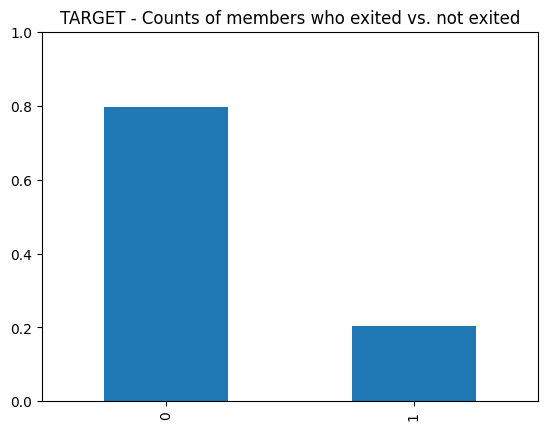

In [21]:
# Retrieve and plot unique counts of the target
# Counts
freq_cnts = data_ohe['Exited'].value_counts()
display(freq_cnts)

# Proportions
freq_prop = data_ohe['Exited'].value_counts(normalize=True)
display(freq_prop)

freq_prop.plot(kind='bar', title='TARGET - Counts of members who exited vs. not exited', ylim=(0.0, 1.0))

##### Constant model comparison

Comparing the model to a constant model is also a type of sanity check that gives us a baseline to ensure the model is behaving as expected. Here the constant model represents a Series of all zeroes. The check is to see if the accuarcy score of the constant model aligns with the accuarcy of our machine learning model.

The accuarcy score of the random forest model with one-hot encoding is <b>0.859</b>.
<br>The accuarcy score of the constant model is <b>0.79</b>.

The accuarcy scores are fairly similar. We are good to proceed with further analysis for this model.

In [23]:
# Create a constant model and compare to the random forest model
pred_constant = pd.Series(0, index=target_ohe_valid.index)
print()
print('Accuracy score of random forest model first run:', accuracy_score(target_ohe_valid, model_rf1_predictions))
print('Accuracy score of constant model:', accuracy_score(target_ohe_valid, pred_constant))


Accuracy score of random forest model first run: 0.859
Accuracy score of constant model: 0.79


#### Confusion matrix

The confusion matrix provides us with more detail into where the model was making incorrect predictions, ie what it is good at doing and what it is not.

- True positives - <b>97%</b> of members that did not exit, were labeled as non-exit members
- True negatives - <b>44%</b> of members that did exit, were labeled as exit members
- False positives - <b>56%</b> of members that did exit, were labeled as non-exit members
- False negatives - <b>3%</b> of members that did not exit, were labeled as exit members

In short, if the customer did exit, the model does a very good job in predicting which customers did not exit. But for exit members, there is some inaccuracy.


Answer counts


array([[1532,   48],
       [ 234,  186]])


Answer proportions


array([[0.96962025, 0.03037975],
       [0.55714286, 0.44285714]])

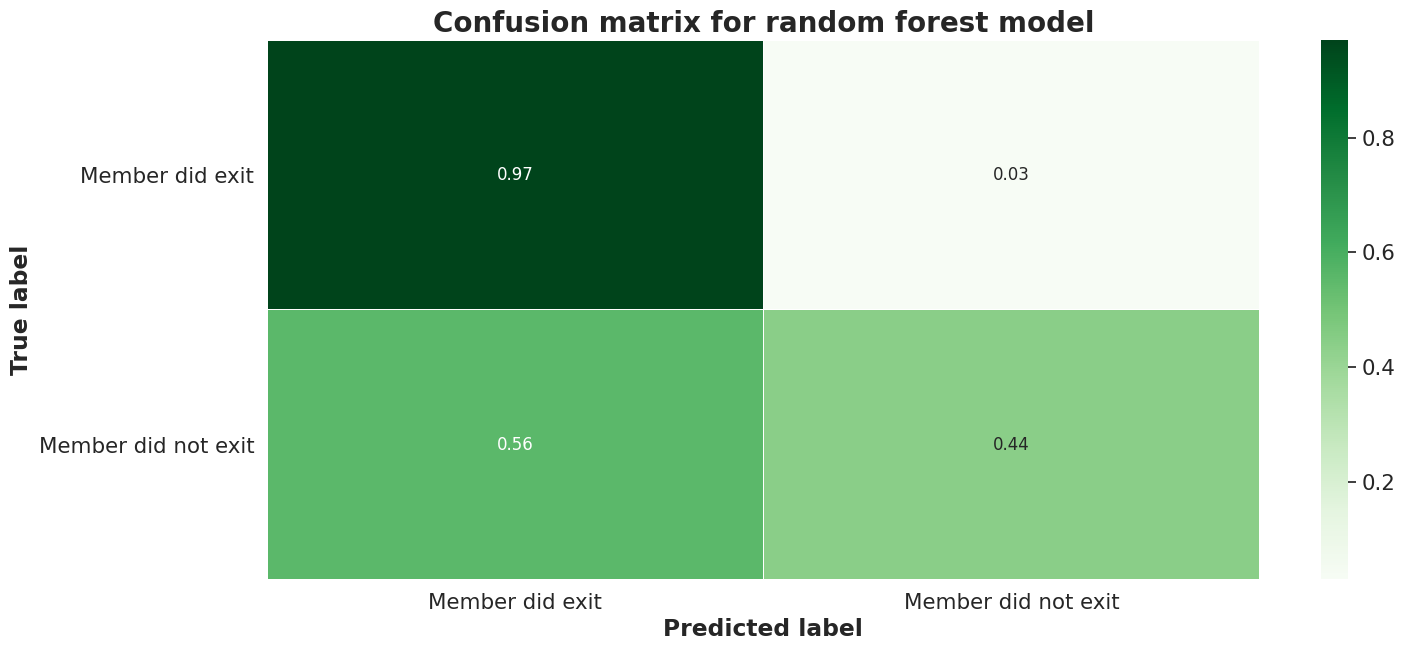

In [24]:
# Create and reshape confusion matrix data
model_rf1_matrix = confusion_matrix(target_ohe_valid, model_rf1_predictions)
print()
print('Answer counts')
display(model_rf1_matrix)
model_rf1_matrix = model_rf1_matrix.astype('float') / model_rf1_matrix.sum(axis=1)[:, np.newaxis]
print()
print('Answer proportions')
display(model_rf1_matrix)

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(model_rf1_matrix, annot=True, annot_kws={'size':12},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Member did exit', 'Member did not exit']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label', fontweight='bold')
plt.ylabel('True label', fontweight='bold')
plt.title('Confusion matrix for random forest model', fontsize=20, fontweight='bold')
plt.show()

#### Metrics review and recap

The metrics here, along with the confusion matrix above, tells the story of the how the model is predicting. Accuracy is fairly high. Where the model is accuartely predicting however is for members that have not exited, represented by the precision metric at <b>0.795</b>. For exit members, there is some inaccuarcy in predicting these members correctly, represented by the recall metric at <b>0.443</b>. This leads to a suboptimal F1 score of <b>0.569</b>. Tinkering needs to be done to improve the model and F1 score.

In [25]:
# Retrieve accuracy score, precision, recall, and f1 score
print()
print('Random forest model (One-hot encoding) metrics')
print()

# Accuracy score
print('Accuracy score:', accuracy_score(target_ohe_valid, model_rf1_predictions))

# Precision
print('Precision:', precision_score(target_ohe_valid, model_rf1_predictions))

# Recall
print('Recall:', recall_score(target_ohe_valid, model_rf1_predictions))

# F1 score
print('F1 score:', f1_score(target_ohe_valid, model_rf1_predictions))


Random forest model (One-hot encoding) metrics

Accuracy score: 0.859
Precision: 0.7948717948717948
Recall: 0.44285714285714284
F1 score: 0.5688073394495412


### Random forest classification - Label encoding

There are two objectives for training a random forest classification model with label encoding. One is to obviously test and see how this type of model performs with the given data. But two, are there any differences in performance between both encoding techniques? Are they similar enough to where we can move forward with one of the models for future improvements, or are they different to the point where encoding did have a substantial difference and both models need to be kept separate.

After running the random forest classification model via <b><font color='red'>label encoding</font></b>, the model performed adequately for a first run. As with the one-hot coding model, the accuarcy score is respectable, but the F1 score can still be improved upon, being lower than our <b>0.59</b> threshold. This infers that there is some precision or recall issues with the performance.

- F1 score: <b>0.564</b>
- Accuracy score: <b>0.858</b>
    
For comparison, here were the one-hot encoding scores.

- F1 score: <b>0.569</b>
- Accuracy score: <b>0.859</b>

In [26]:
# Create and run random forest model with LABEL encoding dataset
model_rf2 = RandomForestClassifier(random_state=12345)
model_rf2.fit(features_labels_train, target_labels_train)
model_rf2_predictions = model_rf2.predict(features_labels_valid)

# Get F1 score of model
print()
print('F1 score:', f1_score(target_labels_valid, model_rf2_predictions))
print('Accuracy score:', accuracy_score(target_labels_valid, model_rf2_predictions))


F1 score: 0.5635528330781011
Accuracy score: 0.8575


#### Sanity checks

##### Value count comparison

The same comparison is done here as a quick sanity check, comparing the target counts, ie acutal <b><mark>Exited</mark></b> counts, from the original dataset to the predicted counts generated from the model.

The original dataset had a class 0 and class 1 distribution of <b>0.7963</b> and <b>0.2037</b> respectively.
<br>The predictions had a class 0 and class 1 distribution of <b>0.884</b> and <b>0.117</b> respectively.

As with the random forest model with one-hot encoding, the label encoding model shows a slight lean to predicting more class 0s, but the proportion is not vastly different, differing by roughly 10%.

For comparison, here were the one-hot encoding proportions. They are nearly identical.
<br>The predictions had a class 0 and class 1 distribution of <b>0.883</b> and <b>0.117</b> respectively.

0    7963
1    2037
Name: Exited, dtype: int64

0    0.7963
1    0.2037
Name: Exited, dtype: float64

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

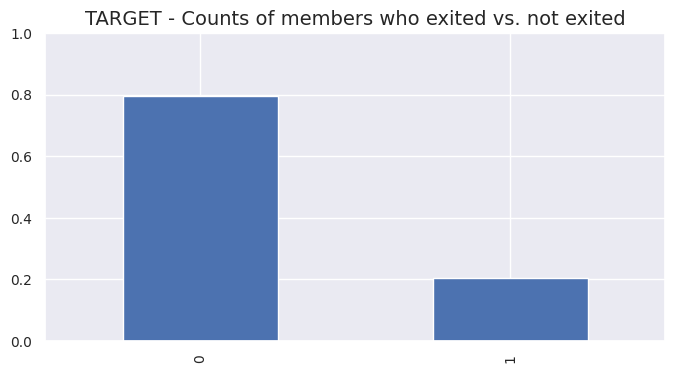

In [27]:
# Retrieve and plot unique counts of the target
# Counts
data_labels['Exited'] = data_labels['Exited'].astype('int')
freq_cnts2 = data_labels['Exited'].value_counts()
display(freq_cnts2)

# Proportions
freq_prop2 = data_labels['Exited'].value_counts(normalize=True)
display(freq_prop2)

freq_prop2.plot(kind='bar', figsize=(8,4), ylim=(0.0, 1.0))
plt.title(label='TARGET - Counts of members who exited vs. not exited', fontsize=14)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)


0    1767
1     233
dtype: int64

0    0.8835
1    0.1165
dtype: float64

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

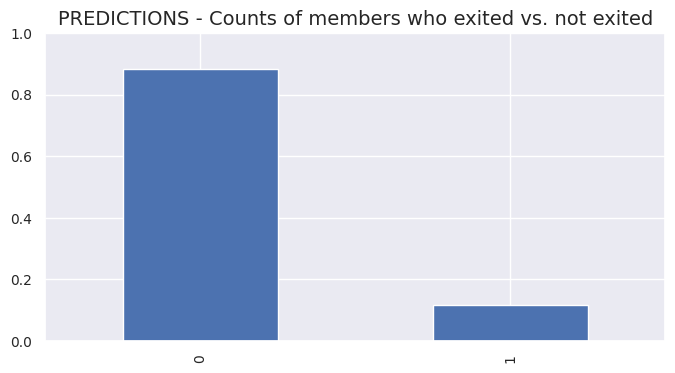

In [28]:
# Retrieve and plot unique counts of the predictions
# Counts
model_rf2_predictions_series = pd.Series(model_rf2_predictions.astype('int'))
freq_props_cnts2 = model_rf2_predictions_series.value_counts()
display(freq_props_cnts2)

# Proportions
freq_props_pred2 = model_rf2_predictions_series.value_counts(normalize=True)
display(freq_props_pred2)

freq_props_pred2.plot(kind='bar', figsize=(8,4), ylim=(0.0, 1.0))
plt.title(label='PREDICTIONS - Counts of members who exited vs. not exited', fontsize=14)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

##### Constant model comparison

The comparison to a constant model is also performed as an additional sanity check. Same as the previous model, the constant model represents a Series of all zeroes. The check is to see if the accuarcy score of the constant model aligns with the accuarcy of our machine learning model.

The accuarcy score of the random forest model with one-hot encoding is <b>0.858</b>.
<br>The accuarcy score of the constant model is <b>0.79</b>.

The accuarcy scores are fairly similar. Also, the accuarcy scores are nearly identical compare to the random forest model with one-hot encoding. Below are the previous model's scores for comparison.

The accuarcy score of the random forest model with one-hot encoding is <b>0.859</b>.

In [29]:
# Create a constant model and compare to the random forest model
pred_constant = pd.Series(0, index=target_ohe_valid.index)
print()
print('Accuracy score of random forest model first run:', accuracy_score(target_ohe_valid, model_rf2_predictions))
print('Accuracy score of constant model:', accuracy_score(target_ohe_valid, pred_constant))


Accuracy score of random forest model first run: 0.8575
Accuracy score of constant model: 0.79


#### Confusion matrix

The confusion matrix provides us with more detail into where the model was making incorrect predictions, ie what it is good at doing and what it is not.

- True positives - <b>97%</b> of members that did not exit, were labeled as non-exit members
- True negatives - <b>44%</b> of members that did exit, were labeled as exit members
- False positives - <b>56%</b> of members that did exit, were labeled as non-exit members
- False negatives - <b>3.1%</b> of members that did not exit, were labeled as exit members

In short, if the customer did exit, the model does a very good job in predicting that the customer did not exit. But for exit members, there is some inaccuracy. This is nearly identical to the one-hot encoding model. Below are the previous model's results for comparison.

- True positives - <b>97%</b> of members that did not exit, were labeled as non-exit members
- True negatives - <b>44%</b> of members that did exit, were labeled as exit members
- False positives - <b>56%</b> of members that did exit, were labeled as non-exit members
- False negatives - <b>3%</b> of members that did not exit, were labeled as exit members


Answer counts


array([[1531,   49],
       [ 236,  184]])


Answer proportions


array([[0.96898734, 0.03101266],
       [0.56190476, 0.43809524]])

Text(0.5, 1.0, 'Confusion matrix for random forest model')

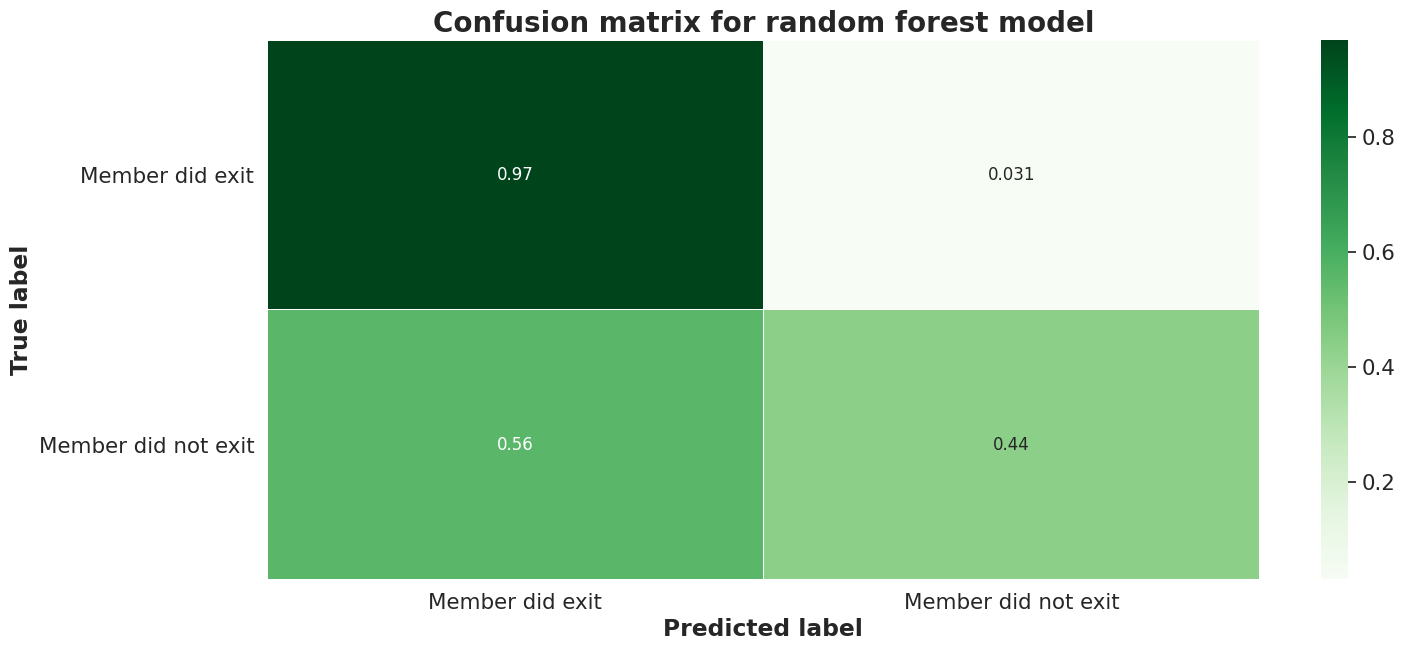

In [30]:
# Create and reshape confusion matrix data
model_rf2_matrix = confusion_matrix(target_ohe_valid, model_rf2_predictions)
print()
print('Answer counts')
display(model_rf2_matrix)
model_rf2_matrix = model_rf2_matrix.astype('float') / model_rf2_matrix.sum(axis=1)[:, np.newaxis]
print()
print('Answer proportions')
display(model_rf2_matrix)

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(model_rf2_matrix, annot=True, annot_kws={'size':12},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Member did exit', 'Member did not exit']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label', fontweight='bold')
plt.ylabel('True label', fontweight='bold')
plt.title('Confusion matrix for random forest model', fontsize=20, fontweight='bold')

#### Metrics review and recap

The metrics here, along with the confusion matrix above, tells the story of the how the model is predicting. Accuracy is fairly high. Where the model is accuartely predicting however is for members that have not exited, represented by the precision metric at <b>0.79</b>. For exit members, there is some inaccuarcy in predicting these members correctly, represented by the recall metric at <b>0.438</b>. This leads to a suboptimal F1 score of <b>0.569</b>.

In [31]:
# Retrieve accuracy score, precision, recall, and f1 score
print()
print('Random forest model (Label encoding) metrics')
print()

# Accuracy score
print('Accuracy score:', accuracy_score(target_ohe_valid, model_rf2_predictions))

# Precision
print('Precision:', precision_score(target_ohe_valid, model_rf2_predictions))

# Recall
print('Recall:', recall_score(target_ohe_valid, model_rf2_predictions))

# F1 score
print('F1 score:', f1_score(target_ohe_valid, model_rf2_predictions))


Random forest model (Label encoding) metrics

Accuracy score: 0.8575
Precision: 0.7896995708154506
Recall: 0.4380952380952381
F1 score: 0.5635528330781011


#### Random forest encoding technique conclusion

After running and analyzing both models, one using one-hot encoding and the other using label encoding, there is not a substantial difference between the two encoding techniques in terms of the model's performance. Both had nearly identical predictions, albeit a couple of records. Therefore, both models do not need to be tested separately. Moving forward to model improvements and testing, the first random forest model using <b><font color='red'>one-hot encoding</font></b> will be used.

### Logistic regression

After running the logistic regression, a bit surprisingly, the model performed poorly for a first run. As with the random forest model, the accuarcy score is respectable, but the F1 score is 25% worse than the random forest model and is also obviously lower than our <b>0.59</b> threshold. This infers that there is some precision or recall issues with the performance. Let's take a deeper dive.

- F1 score: <b>0.278</b>
- Accuracy score: <b>0.803</b>

In [32]:
# Create and run logistic regression model
model_lr = LogisticRegression(random_state=12345)
model_lr.fit(features_ohe_train, target_ohe_train)
model_lr_predictions = model_lr.predict(features_ohe_valid)

# Get F1 score of model
print()
print('F1 score:', f1_score(target_ohe_valid, model_lr_predictions))
print('Accuracy score:', accuracy_score(target_ohe_valid, model_lr_predictions))


F1 score: 0.27787934186471663
Accuracy score: 0.8025


#### Sanity checks

##### Value count comparison

The same comparison is done here as a quick sanity check, comparing the target counts, ie acutal <b><mark>Exited</mark></b> counts, from the original dataset to the predicted counts generated from the model.

The original dataset had a class 0 and class 1 distribution of <b>0.7963</b> and <b>0.2037</b> respectively.
<br>The predictions had a class 0 and class 1 distribution of <b>0.937</b> and <b>0.064</b> respectively.

The model shows a slight lean to predicting more class 0s, but the proportion is not vastly different, but it does differ by over 10%. This is not of surprise given the F1 score presented earlier. It seems the model is predicting more 0s than there actually are.

0    7963
1    2037
Name: Exited, dtype: int64

0    0.7963
1    0.2037
Name: Exited, dtype: float64

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

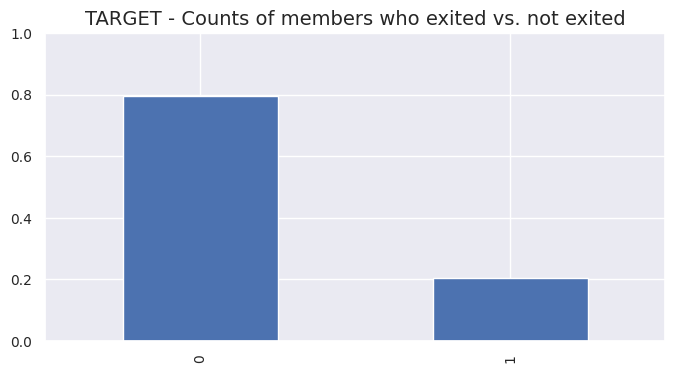

In [33]:
# Retrieve and plot unique counts of the target
# Counts
data_ohe['Exited'] = data_ohe['Exited'].astype('int')
freq_cnts3 = data_ohe['Exited'].value_counts()
display(freq_cnts3)

# Proportions
freq_prop3 = data_ohe['Exited'].value_counts(normalize=True)
display(freq_prop3)

freq_prop3.plot(kind='bar', figsize=(8,4), ylim=(0.0, 1.0))
plt.title(label='TARGET - Counts of members who exited vs. not exited', fontsize=14)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

0    1873
1     127
dtype: int64

0    0.9365
1    0.0635
dtype: float64

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

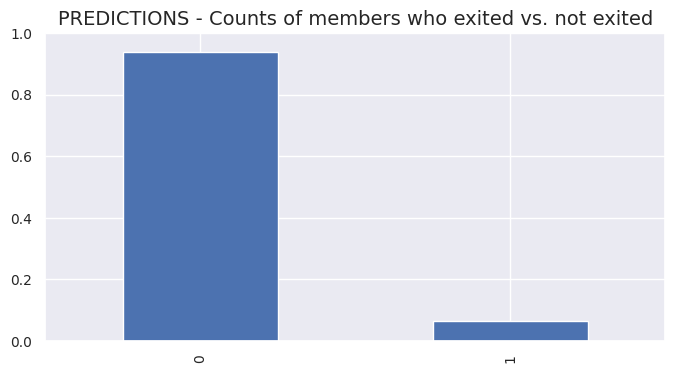

In [34]:
# Retrieve and plot unique counts of the predictions
# Counts
model_lr_predictions_series = pd.Series(model_lr_predictions.astype('int'))
freq_props_cnts3 = model_lr_predictions_series.value_counts()
display(freq_props_cnts3)

# Proportions
freq_props_pred3 = model_lr_predictions_series.value_counts(normalize=True)
display(freq_props_pred3)

freq_props_pred3.plot(kind='bar', figsize=(8,4), ylim=(0.0, 1.0))
plt.title(label='PREDICTIONS - Counts of members who exited vs. not exited', fontsize=14)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

##### Constant model comparison

The comparison to a constant model is also performed as an additional sanity check. The constant model represents a Series of all zeroes. The check is to see if the accuarcy score of the constant model aligns with the accuarcy of our machine learning model.

The accuarcy score of the logistic regression is <b>0.803</b>.
<br>The accuarcy score of the constant model is <b>0.79</b>.

The accuarcy scores are nearly identical. We are good to proceed with further analysis for this model.

In [35]:
# Create a constant model and compare to the random forest model
pred_constant = pd.Series(0, index=target_ohe_valid.index)
print()
print('Accuracy score of random forest model first run:', accuracy_score(target_ohe_valid, model_lr_predictions))
print('Accuracy score of constant model:', accuracy_score(target_ohe_valid, pred_constant))


Accuracy score of random forest model first run: 0.8025
Accuracy score of constant model: 0.79


#### Confusion matrix

The confusion matrix provides us with more detail into where the model was making incorrect predictions, ie what it is good at doing and what it is not.

- True positives - <b>97%</b> of members that did not exit, were labeled as non-exit members
- True negatives - <b>18%</b> of members that did exit, were labeled as exit members
- False positives - <b>82%</b> of members that did exit, were labeled as non-exit members
- False negatives - <b>3.2%</b> of members that did not exit, were labeled as exit members

As with the random forest model, the logistic regression model does a very good job in predicting which customers did not exit. But for exit members, there is some inaccuracy. And here is where the differenes reside between both models. For the logistic regression, there are many more false positives, which is resulting in a worse F1 score. Only <b>18%</b> of class 1s are being predicted correctly.


Answer counts


array([[1529,   51],
       [ 344,   76]])


Answer proportions


array([[0.96772152, 0.03227848],
       [0.81904762, 0.18095238]])

Text(0.5, 1.0, 'Confusion matrix for random forest model')

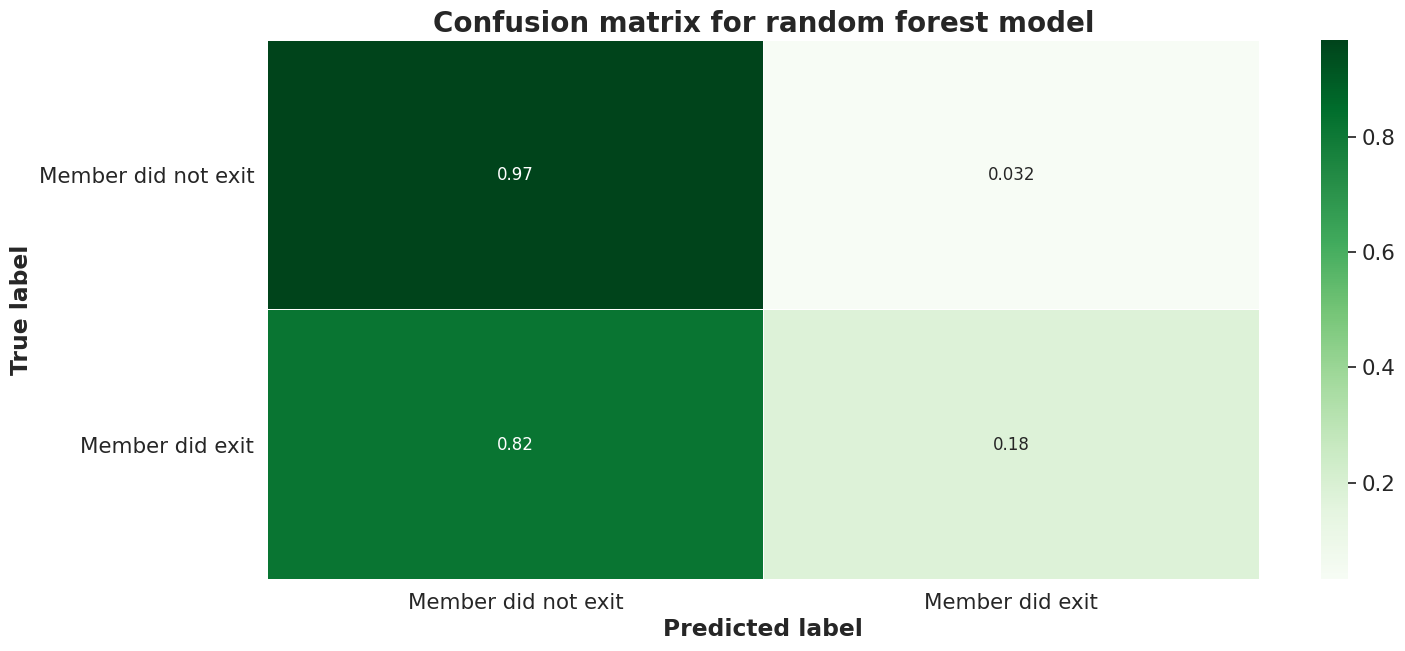

In [36]:
# Create and reshape confusion matrix data
model_lr_matrix = confusion_matrix(target_ohe_valid, model_lr_predictions)
print()
print('Answer counts')
display(model_lr_matrix)
model_lr_matrix = model_lr_matrix.astype('float') / model_lr_matrix.sum(axis=1)[:, np.newaxis]
print()
print('Answer proportions')
display(model_lr_matrix)

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(model_lr_matrix, annot=True, annot_kws={'size':12},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Member did not exit', 'Member did exit']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label', fontweight='bold')
plt.ylabel('True label', fontweight='bold')
plt.title('Confusion matrix for random forest model', fontsize=20, fontweight='bold')

#### Metrics review and recap

The metrics here, along with the confusion matrix above, tells the story of the how the model is predicting. Accuracy is fairly high. Where the model is accuartely predicting however is for members that have not exited, represented by the precision metric at <b>0.59</b>. For exit members, there is some inaccuarcy in predicting these members correctly, represented by the recall metric at <b>0.18</b>. This leads to a suboptimal F1 score of <b>0.278</b>.

In [37]:
# Retrieve accuracy score, precision, recall, and f1 score
print()
print('Logisitc regression metrics')
print()

# Accuracy score
print('Accuracy score:', accuracy_score(target_ohe_valid, model_lr_predictions))

# Precision
print('Precision:', precision_score(target_ohe_valid, model_lr_predictions))

# Recall
print('Recall:', recall_score(target_ohe_valid, model_lr_predictions))

# F1 score
print('F1 score:', f1_score(target_ohe_valid, model_lr_predictions))


Logisitc regression metrics

Accuracy score: 0.8025
Precision: 0.5984251968503937
Recall: 0.18095238095238095
F1 score: 0.27787934186471663


### Conclusion

After the initial runs, both models do not meet the F1 score threshold of <b>0.59</b>. Even after certain preprocessing techniques, they still are missing the mark. There might class imbalance fixing or model improvements that need to be done to yield better results and a higher F1 score.

## Class imbalance analysis and improvements

When the distribution of data across classes in a dataset is highly uneven, meaning that one class has significantly more samples compared to other classes, this can negatively impact the performance of a model. This is called a class imbalance. Could the low F1 scores, all being below the <b>0.59</b> threshold, be caused by a class imbalance in the data?

First, a class imbalance within the dataset was verified by attaining counts of the target, or <b><mark>Exited</mark></b> field. <b>Upsamling</b> and <b>threshold adjusmtent</b> techniques were then applied to the dataset to mitigate the effects of the imbalance.

### Is there a class imbalance?

There is clear class imbalance in the dataset. Counts within the training dataset are about a 80 / 20 split. This difference in the number of samples could be having a negative on the model.

- Class 0 - 4797 | <b>79.9%</b>
- Class 1 - 1203 | <b>20%</b>




SHAPE


(6000, 11)


COUNTS OF TARGET


(6000,)

0    4797
1    1203
Name: Exited, dtype: int64

Text(0.5, 1.0, 'Member distribution')

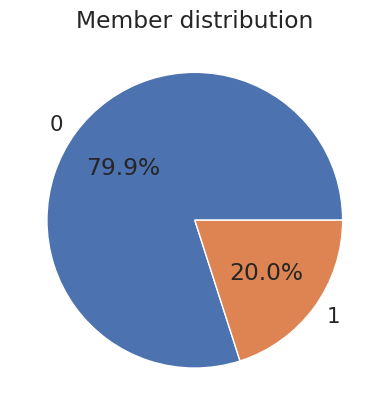

In [38]:
# Find shape of features and target for training dataset
print()
print('SHAPE')
display(features_ohe_train.shape)
print()
print('COUNTS OF TARGET')
display(target_ohe_train.shape)

# Find counts of target
target_train_cnts = target_ohe_train.value_counts()
display(target_train_cnts)

# Plot pie chart
plot1 = target_train_cnts.plot.pie(autopct='%1.1f%%')
plot1.set_ylabel('')
plt.title('Member distribution')

### Upsampling

Upsamling was the first technique performed to mitigate the class imbalanace in the data. Or in other words, duplicating the number of class 1 samples in the data so they are more even with the number of class 0 samples. The upsampling process was a 4-step process.

- Split the training sample into negative and positive observations
- Duplicate the positive observations by a <b><font color='red'>factor of 4</font></b>
- Create a new training sample based on the data obtained
- Shuffle the data

After the data was upsampled, the class 1s records now portray a representative portion of the dataset.

Old counts

- Class 0 - <b>4797</b>
- Class 1 - <b>1203</b>

New counts

- Class 0 - <b>4797</b>
- Class 1 - <b>4812</b>


In [39]:
# Split training dataset into class 0s and 1s
features_ohe_train_zeroes = features_ohe_train[target_ohe_train == 0]
features_ohe_train_ones = features_ohe_train[target_ohe_train == 1]
target_ohe_train_zeroes = target_ohe_train[target_ohe_train == 0]
target_ohe_train_ones = target_ohe_train[target_ohe_train == 1]

# Duplicate the class 1 observations by a factor of 4
features_train_upsampled = pd.concat([features_ohe_train_zeroes] + [features_ohe_train_ones] * 4)
target_train_upsampled = pd.concat([target_ohe_train_zeroes] + [target_ohe_train_ones] * 4)

# Shuffle the data
features_train_upsampled, target_train_upsampled = shuffle(features_train_upsampled, target_train_upsampled, random_state=12345)

# Display old shape and counts versus new shape and counts
print()
print('OLD SHAPE AND COUNTS')
display(features_ohe_train.shape)
display(target_ohe_train.shape)
display(target_ohe_train.value_counts())
print()
print('NEW SHAPE AND COUNTS')
display(features_train_upsampled.shape)
display(target_train_upsampled.shape)
display(target_train_upsampled.value_counts())


OLD SHAPE AND COUNTS


(6000, 11)

(6000,)

0    4797
1    1203
Name: Exited, dtype: int64


NEW SHAPE AND COUNTS


(9609, 11)

(9609,)

1    4812
0    4797
Name: Exited, dtype: int64

### Threshold adjustment

The second technique that was applied to mitigate the class imbalance in the data was <b>adjusting the thresholds</b>. A threshold is a specific value that acts as a cut-off point to determine the final classification of a prediction. Anything above the threshold is considered class 1 and anything below the threshold is class 0. Can we improve the performance of the models by updating the threshold value to a different value?

#### Random forest

A precision-recall curve, or PR curve, reveals at what thresholds the model yields the best precisions and recalls. It is a easy to comprehend visual that determines what threshold may be best for a particular model.

For the random forest classification model, the PR curve shows that the best precisions and recalls together reside between 0.2 and 0.8. Thresholds outside of this range have too big of inaccuracies. A for loop iterating over this range concludes that a threshold <b><font color='red'>0.5</font></b> is the optimal threshold, having a F1 score of <b>0.594</b>.

However, <b>0.5</b> is the default threshold for the algorithm to begin with. So, there is actually no change needed to the threshold for the model. The optimal threshold is already in place! 

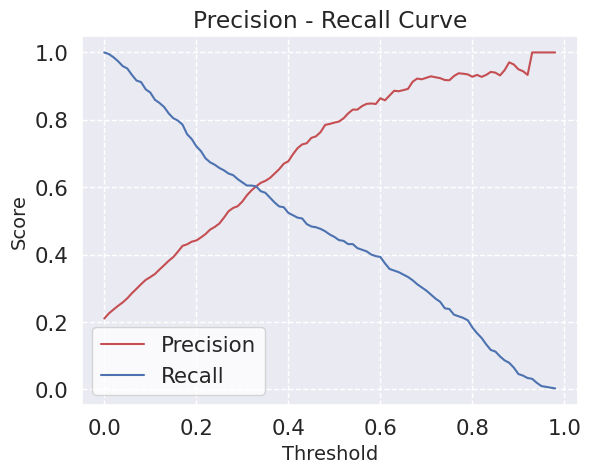

In [40]:
# Find class 1 probabilities and create PR curve
probabilities_rf = model_rf1.predict_proba(features_ohe_valid)
probabilities_rf_one = probabilities_rf[:, 1]
precision, recall, threshold = precision_recall_curve(target_ohe_valid, probabilities_rf_one)

# Plot PR curve
plt.plot(threshold, precision[:-1], c ='r', label ='Precision') 
plt.plot(threshold, recall[:-1], c ='b', label ='Recall') 
plt.grid(axis='both', linestyle = '--', color='white') 
plt.legend(facecolor='white')
plt.title('Precision - Recall Curve')
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.grid(axis='both', linestyle = '--', color='white')

In [41]:
for threshold in np.arange(0.2, 0.8, 0.1):
    predicted = probabilities_rf_one > threshold
    precision = precision_score(target_ohe_valid, predicted)
    recall = recall_score(target_ohe_valid, predicted)
    F1_score = f1_score(target_ohe_valid, predicted)
    print('Threshold = {:.2f} | Precision = {:.3f} | Recall = {:.3f} | F1 score = {:.3f}'.format(threshold, precision, recall, F1_score))

Threshold = 0.20 | Precision = 0.451 | Recall = 0.707 | F1 score = 0.551
Threshold = 0.30 | Precision = 0.576 | Recall = 0.605 | F1 score = 0.590
Threshold = 0.40 | Precision = 0.698 | Recall = 0.517 | F1 score = 0.594
Threshold = 0.50 | Precision = 0.795 | Recall = 0.443 | F1 score = 0.569
Threshold = 0.60 | Precision = 0.858 | Recall = 0.374 | F1 score = 0.521
Threshold = 0.70 | Precision = 0.929 | Recall = 0.281 | F1 score = 0.431
Threshold = 0.80 | Precision = 0.933 | Recall = 0.167 | F1 score = 0.283


#### Logistic regression

For the logisitic regression classification model, the PR curve shows that the best precisions and recalls together reside between -2.0 and 1.0. Thresholds outside of this range have too big of inaccuracies. A for loop iterating over this range concludes that a threshold <b><font color='red'>-1.2</font></b> is the optimal threshold.

The F1 score at a <b>-1.2</b> threshold is <b>0.507</b>. This threshold will be used in future testing for the logistic regression model.

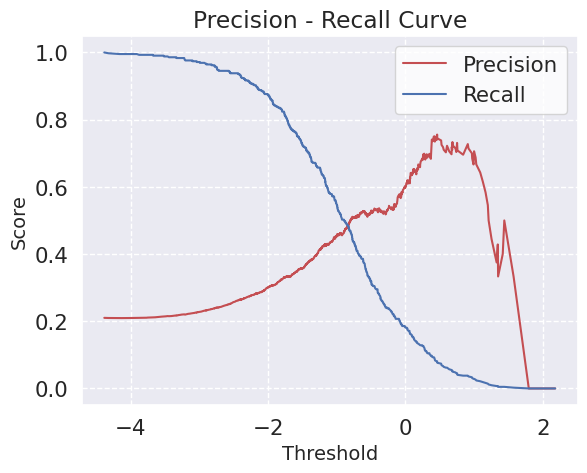

In [42]:
# Find class 1 probabilities and create PR curve
probabilities_lr = model_lr.decision_function(features_ohe_valid) 
precision, recall, threshold = precision_recall_curve(target_ohe_valid, probabilities_lr)

# Plot PR curve
plt.plot(threshold, precision[:-1], c ='r', label ='Precision') 
plt.plot(threshold, recall[:-1], c ='b', label ='Recall') 
plt.grid(axis='both', linestyle = '--', color='white') 
plt.legend(facecolor='white')
plt.title('Precision - Recall Curve')
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.grid(axis='both', linestyle = '--', color='white') 

In [43]:
for threshold in np.arange(-2.0, 1.0, 0.2):
    predicted = probabilities_lr > threshold
    precision = precision_score(target_ohe_valid, predicted)
    recall = recall_score(target_ohe_valid, predicted)
    F1_score = f1_score(target_ohe_valid, predicted)
    print('Threshold = {:.2f} | Precision = {:.3f} | Recall = {:.3f} | F1 score = {:.3f}'.format(threshold, precision, recall, F1_score))

Threshold = -2.00 | Precision = 0.301 | Recall = 0.874 | F1 score = 0.448
Threshold = -1.80 | Precision = 0.326 | Recall = 0.829 | F1 score = 0.467
Threshold = -1.60 | Precision = 0.346 | Recall = 0.762 | F1 score = 0.476
Threshold = -1.40 | Precision = 0.378 | Recall = 0.698 | F1 score = 0.490
Threshold = -1.20 | Precision = 0.423 | Recall = 0.633 | F1 score = 0.507
Threshold = -1.00 | Precision = 0.455 | Recall = 0.545 | F1 score = 0.496
Threshold = -0.80 | Precision = 0.503 | Recall = 0.467 | F1 score = 0.484
Threshold = -0.60 | Precision = 0.525 | Recall = 0.371 | F1 score = 0.435
Threshold = -0.40 | Precision = 0.524 | Recall = 0.283 | F1 score = 0.368
Threshold = -0.20 | Precision = 0.539 | Recall = 0.229 | F1 score = 0.321
Threshold = -0.00 | Precision = 0.598 | Recall = 0.181 | F1 score = 0.278
Threshold = 0.20 | Precision = 0.663 | Recall = 0.131 | F1 score = 0.219
Threshold = 0.40 | Precision = 0.750 | Recall = 0.093 | F1 score = 0.165
Threshold = 0.60 | Precision = 0.722 | R

## Model quality improvements

### Tuning hyperparameters

Now that the class imbalance in the data has been resolved, next task is to improve the quality of the model by updating certain hyperparameters. For the random forest model, <b>n_estimators</b>, <b>max_depth</b>, <b>min_samples_leaf</b>, and <b>min_samples_split</b> were all tested to see if updating their values would yield better results and accuracy. For the logistic regression model, <b>solver</b>, <b>penalty</b>, <b>C</b>, and <b>max_iter</b> were tested. After the parameters were tinkered with, the best possible combination of parameters were identified using a gridsearch object. These combinations are going to be used in the final evaluation of the both models.

#### Random forest

##### n_estimators

<b>n_estimators</b> represents the number of trees in the forest. It might be thought that using many trees to fit a model will help to get a more generalized result, but this is not always the case, so analysis was done to identify the best values.

Many estimator values and ranges were investigated. The estimator range between 1 - 10 yielded the lowest accuracies and F1 scores. From here, the scores steadily increased the higher the estimator values became, peaking at a range between 70 - 80. For values after this range, accuracies and F1 scores no longer increased, and rather they started to decrease once the estimator values cleared 100.

The best results came within the range <b><font color='red'>70</font></b> - <b><font color='red'>80</font></b>, where <b>0.601</b> was the highest F1 score achieved. These values will be used for the <b>n_estimator</b> parameter in future predictions and modeling.

In [44]:
# Compare n_estimator values (range 1-10)
for estimator in range(1, 11):
    model_rf1 = RandomForestClassifier(n_estimators=estimator, random_state=12345)
    model_rf1.fit(features_train_upsampled, target_train_upsampled)
    preds_valid = model_rf1.predict(features_ohe_valid)
    print('n_estimators: =', estimator, ': ', end='')
    print(accuracy_score(target_ohe_valid, preds_valid).round(3), '| ', end='')
    print(f1_score(target_ohe_valid, preds_valid).round(3))

n_estimators: = 1 : 0.758 | 0.477
n_estimators: = 2 : 0.821 | 0.444
n_estimators: = 3 : 0.808 | 0.52
n_estimators: = 4 : 0.826 | 0.49
n_estimators: = 5 : 0.819 | 0.541
n_estimators: = 6 : 0.828 | 0.519
n_estimators: = 7 : 0.826 | 0.555
n_estimators: = 8 : 0.838 | 0.541
n_estimators: = 9 : 0.838 | 0.582
n_estimators: = 10 : 0.837 | 0.552


In [45]:
# Compare n_estimator values (range 70-80)
for estimator in range(70, 81):
    model_rf1 = RandomForestClassifier(n_estimators=estimator, random_state=12345)
    model_rf1.fit(features_train_upsampled, target_train_upsampled)
    preds_valid = model_rf1.predict(features_ohe_valid)
    print('n_estimators: =', estimator, ': ', end='')
    print(accuracy_score(target_ohe_valid, preds_valid).round(3), '| ', end='')
    print(f1_score(target_ohe_valid, preds_valid).round(3))

n_estimators: = 70 : 0.852 | 0.591
n_estimators: = 71 : 0.85 | 0.59
n_estimators: = 72 : 0.852 | 0.589
n_estimators: = 73 : 0.852 | 0.595
n_estimators: = 74 : 0.852 | 0.592
n_estimators: = 75 : 0.852 | 0.598
n_estimators: = 76 : 0.853 | 0.595
n_estimators: = 77 : 0.854 | 0.601
n_estimators: = 78 : 0.852 | 0.594
n_estimators: = 79 : 0.854 | 0.601
n_estimators: = 80 : 0.852 | 0.593


##### max_depth

The range of values first invesigated for the <b>max_depth</b> parameter was 1 - 25. Accuracies and F1 scores jump after a <b>max_depth</b> of <b>8</b>, where F1 scores hit higher 50s. The rest of the max_depth values within this range hover around a F1 score of 0.60, where a depth of <b>10</b> is the first depth we see with a <b>60%</b> F1 score, and depth <b>16</b> is the depth with the highest F1 score at <b>0.606</b>. For values after this range, so from 26 and beyond, the exact same F1 score is achieved no matter how high the value is.

It is clear that the optimal range for the <b>max_depth</b> parameter is between <b><font color='red'>10</font></b> - <b><font color='red'>20</font></b>. These values will be used in future predictions and modeling.

In [48]:
# Compare max_depth values (range 1-25)
for depth in range(1, 26):
    model_rf1 = RandomForestClassifier(max_depth=depth, random_state=12345)
    model_rf1.fit(features_train_upsampled, target_train_upsampled)
    preds_valid = model_rf1.predict(features_ohe_valid)
    print('max_depth =', depth, ': ', end='')
    print(accuracy_score(target_ohe_valid, preds_valid).round(3), '| ', end='')
    print(f1_score(target_ohe_valid, preds_valid).round(3))

max_depth = 1 : 0.738 | 0.505
max_depth = 2 : 0.738 | 0.507
max_depth = 3 : 0.764 | 0.541
max_depth = 4 : 0.772 | 0.549
max_depth = 5 : 0.78 | 0.561
max_depth = 6 : 0.78 | 0.562
max_depth = 7 : 0.796 | 0.584
max_depth = 8 : 0.806 | 0.592
max_depth = 9 : 0.816 | 0.595
max_depth = 10 : 0.822 | 0.605
max_depth = 11 : 0.826 | 0.598
max_depth = 12 : 0.834 | 0.595
max_depth = 13 : 0.838 | 0.597
max_depth = 14 : 0.844 | 0.601
max_depth = 15 : 0.844 | 0.6
max_depth = 16 : 0.85 | 0.606
max_depth = 17 : 0.85 | 0.6
max_depth = 18 : 0.85 | 0.593
max_depth = 19 : 0.854 | 0.602
max_depth = 20 : 0.854 | 0.602
max_depth = 21 : 0.848 | 0.584
max_depth = 22 : 0.852 | 0.594
max_depth = 23 : 0.854 | 0.6
max_depth = 24 : 0.853 | 0.595
max_depth = 25 : 0.854 | 0.6


In [49]:
# Compare max_depth values (range 25-35)
for depth in range(26, 36):
    model_rf1 = RandomForestClassifier(max_depth=depth, random_state=12345)
    model_rf1.fit(features_train_upsampled, target_train_upsampled)
    preds_valid = model_rf1.predict(features_ohe_valid)
    print('max_depth =', depth, ': ', end='')
    print(accuracy_score(target_ohe_valid, preds_valid).round(3), '| ', end='')
    print(f1_score(target_ohe_valid, preds_valid).round(3))

max_depth = 26 : 0.854 | 0.596
max_depth = 27 : 0.853 | 0.596
max_depth = 28 : 0.853 | 0.596
max_depth = 29 : 0.853 | 0.596
max_depth = 30 : 0.853 | 0.596
max_depth = 31 : 0.853 | 0.596
max_depth = 32 : 0.853 | 0.596
max_depth = 33 : 0.853 | 0.596
max_depth = 34 : 0.853 | 0.596
max_depth = 35 : 0.853 | 0.596


##### min_samples_leaf

A range of 1 - 25 was first selected for testing the <b>min_samples_leaf</b> parameter. Looking at the accuracies and F1 scores, they do not change much, hovering around <b>0.58</b> and <b>0.59</b>. The highest F1 score is actually at sample <b>1</b> with a F1 score of <b>0.596</b>. From this point, the scores continuously decrease the higher the <b>min_sample_leaf</b> value. For example, at range 90 - 100, the score dip to <b>0.56</b>.

Updating the <b>min_samples_leaf</b> parameters is not yielding any improvement in terms of accuracy and F1 score. Therefore, updating this parameter will not be part of future modeling and will be left at its default value.

In [50]:
# Compare min_samples_leaf values (range 1-10)
for leaf_samples in range(1, 26):
    model_rf1 = RandomForestClassifier(min_samples_leaf=leaf_samples, random_state=12345)
    model_rf1.fit(features_train_upsampled, target_train_upsampled)
    preds_valid = model_rf1.predict(features_ohe_valid)
    print('min_samples_leaf: =', leaf_samples, ': ', end='')
    print(accuracy_score(target_ohe_valid, preds_valid).round(3), '| ', end='')
    print(f1_score(target_ohe_valid, preds_valid).round(3))

min_samples_leaf: = 1 : 0.853 | 0.596
min_samples_leaf: = 2 : 0.838 | 0.592
min_samples_leaf: = 3 : 0.836 | 0.594
min_samples_leaf: = 4 : 0.829 | 0.592
min_samples_leaf: = 5 : 0.826 | 0.592
min_samples_leaf: = 6 : 0.824 | 0.595
min_samples_leaf: = 7 : 0.819 | 0.589
min_samples_leaf: = 8 : 0.816 | 0.589
min_samples_leaf: = 9 : 0.812 | 0.584
min_samples_leaf: = 10 : 0.811 | 0.589
min_samples_leaf: = 11 : 0.814 | 0.592
min_samples_leaf: = 12 : 0.814 | 0.596
min_samples_leaf: = 13 : 0.806 | 0.585
min_samples_leaf: = 14 : 0.81 | 0.589
min_samples_leaf: = 15 : 0.808 | 0.593
min_samples_leaf: = 16 : 0.808 | 0.589
min_samples_leaf: = 17 : 0.805 | 0.585
min_samples_leaf: = 18 : 0.802 | 0.58
min_samples_leaf: = 19 : 0.802 | 0.581
min_samples_leaf: = 20 : 0.8 | 0.58
min_samples_leaf: = 21 : 0.8 | 0.579
min_samples_leaf: = 22 : 0.801 | 0.581
min_samples_leaf: = 23 : 0.806 | 0.587
min_samples_leaf: = 24 : 0.797 | 0.579
min_samples_leaf: = 25 : 0.792 | 0.571


In [51]:
# Compare min_samples_leaf values (range 90-101)
for leaf_samples in range(90, 101):
    model_rf1 = RandomForestClassifier(min_samples_leaf=leaf_samples, random_state=12345)
    model_rf1.fit(features_train_upsampled, target_train_upsampled)
    preds_valid = model_rf1.predict(features_ohe_valid)
    print('min_samples_leaf: =', leaf_samples, ': ', end='')
    print(accuracy_score(target_ohe_valid, preds_valid).round(3), '| ', end='')
    print(f1_score(target_ohe_valid, preds_valid).round(3))

min_samples_leaf: = 90 : 0.772 | 0.555
min_samples_leaf: = 91 : 0.776 | 0.562
min_samples_leaf: = 92 : 0.776 | 0.562
min_samples_leaf: = 93 : 0.776 | 0.561
min_samples_leaf: = 94 : 0.776 | 0.559
min_samples_leaf: = 95 : 0.776 | 0.562
min_samples_leaf: = 96 : 0.775 | 0.559
min_samples_leaf: = 97 : 0.778 | 0.563
min_samples_leaf: = 98 : 0.777 | 0.563
min_samples_leaf: = 99 : 0.774 | 0.56
min_samples_leaf: = 100 : 0.776 | 0.565


##### min_samples_split

A range of 2 - 40 was investigated for the <b>min_samples_split</b> parameter. At sample value <b>10</b>, scores start to hit above 0.60. After value 10, all scores hover around the <b>0.60</b> mark, with sample value <b>20</b> yielding the highest F1 score at <b>0.607</b>.

Most of the values yield similar accuracies and F1 scores, but there is a slight increase above <b>min_samples_split</b> value 10, where scores are above 0.60. The range of <b><font color='red'>10</font></b> - <b><font color='red'>40</font></b> will be used for future predictions and modeling.

In [52]:
# Compare min_samples_split values
for split_samples in range(2, 41):
    model_rf1 = RandomForestClassifier(min_samples_split=split_samples, random_state=12345)
    model_rf1.fit(features_train_upsampled, target_train_upsampled)
    preds_valid = model_rf1.predict(features_ohe_valid)
    print('min_samples_split =', split_samples, ':', end='')
    print(accuracy_score(target_ohe_valid, preds_valid).round(3), '| ', end='')
    print(f1_score(target_ohe_valid, preds_valid).round(3))

min_samples_split = 2 :0.853 | 0.596
min_samples_split = 3 :0.846 | 0.58
min_samples_split = 4 :0.851 | 0.598
min_samples_split = 5 :0.848 | 0.596
min_samples_split = 6 :0.848 | 0.599
min_samples_split = 7 :0.848 | 0.599
min_samples_split = 8 :0.84 | 0.588
min_samples_split = 9 :0.841 | 0.594
min_samples_split = 10 :0.84 | 0.594
min_samples_split = 11 :0.84 | 0.602
min_samples_split = 12 :0.84 | 0.603
min_samples_split = 13 :0.84 | 0.61
min_samples_split = 14 :0.837 | 0.603
min_samples_split = 15 :0.834 | 0.604
min_samples_split = 16 :0.836 | 0.606
min_samples_split = 17 :0.833 | 0.6
min_samples_split = 18 :0.833 | 0.6
min_samples_split = 19 :0.835 | 0.61
min_samples_split = 20 :0.832 | 0.607
min_samples_split = 21 :0.83 | 0.6
min_samples_split = 22 :0.83 | 0.606
min_samples_split = 23 :0.827 | 0.6
min_samples_split = 24 :0.824 | 0.595
min_samples_split = 25 :0.824 | 0.596
min_samples_split = 26 :0.826 | 0.601
min_samples_split = 27 :0.824 | 0.597
min_samples_split = 28 :0.823 | 0.598


##### gridsearch

To find the best combination of hyperparameters, a <b>gridsearch</b> object was created to test all possible combinations based on the ideal range of values that were previously identified. The parameter grid includes the following parameters and values that were used in the calculation.

<b>NOTE</b>: not all values within the specified ranges were used in the parameter grid because of decreased performance and time. The gridsearch object takes some time to run through all the possible combinations, so only some values were chosen within the ranges specified during the previous analysis.

- <b>n_esimtators</b>: 9, 60, 70, 79
- <b>max_depth</b>: 10, 12, 15, 18, 20
- <b>min_samples_split</b>: 2, 10, 15, 20, 25, 30

In [53]:
# Compare values of all hyperparameters
# Create parameter grid
param_grid_rf1 = {'n_estimators': [9, 60, 70, 79],
              'max_depth': [10, 12, 15, 18, 20],
              'min_samples_split': [2, 10, 15, 20, 25, 30]}

# Create gridsearch object
model_rf1_grid = RandomForestClassifier(random_state=12345)
grid_search_rf1 = GridSearchCV(estimator=model_rf1_grid, param_grid=param_grid_rf1, cv=5, scoring='f1')

# Fit model and identify best hyperparameter combinations
grid_search_rf1.fit(features_train_upsampled, target_train_upsampled)
grid_search_rf1.cv_results_
dict_rf1 = defaultdict(partial(np.ndarray, 0))
dict_rf1['params'] = grid_search_rf1.cv_results_['params']
dict_rf1['split0_test_score'] = grid_search_rf1.cv_results_['split0_test_score']
dict_rf1['split1_test_score'] = grid_search_rf1.cv_results_['split1_test_score']
dict_rf1['split2_test_score'] = grid_search_rf1.cv_results_['split2_test_score']
dict_rf1['mean_valid_score'] = grid_search_rf1.cv_results_['mean_test_score']
print("Best hyperparameters:", grid_search_rf1.best_params_)
print("Best F1 score:", grid_search_rf1.best_score_)
print()
print()
display(dict_rf1)

Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 60}
Best F1 score: 0.9571924684760461




defaultdict(functools.partial(<class 'numpy.ndarray'>, 0),
            {'params': [{'max_depth': 10,
               'min_samples_split': 2,
               'n_estimators': 9},
              {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 60},
              {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 70},
              {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 79},
              {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 9},
              {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 60},
              {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 70},
              {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 79},
              {'max_depth': 10, 'min_samples_split': 15, 'n_estimators': 9},
              {'max_depth': 10, 'min_samples_split': 15, 'n_estimators': 60},
              {'max_depth': 10, 'min_samples_split': 15, 'n_estimators': 70},
              {'max_depth': 10, 'min_samples_split

##### Optimized model run

The fully optimized random forest model has an accuracy of <b>0.858</b> and a F1 score of <b>0.607</b>. Over the threshold of <b>0.59</b>! The following hyperparameter combination will be used to train the model during final evaluation.

- <b>n_estimator</b>: 60
- <b>max_depth</b>: 20
- <b>min_samples_split</b>: 2

In [54]:
# Get predictions and scores with new hyperparameter values
model_rf1 = RandomForestClassifier(n_estimators=60, max_depth=20, min_samples_split=2, random_state=12345)
model_rf1.fit(features_train_upsampled, target_train_upsampled)
preds_valid = model_rf1.predict(features_ohe_valid)
print('Accuracy score:', accuracy_score(target_ohe_valid, preds_valid).round(3))
print('F1 score', f1_score(target_ohe_valid, preds_valid).round(3))

Accuracy score: 0.858
F1 score 0.607


#### Logistic regression

For the logistic regression model, there were not many values of the hyperparameters that needed to be investigated. So, a <b>gridsearch</b> object was created at the start to find the best combination for the following hyperparameters: <b>solver</b>, <b>penalty</b>, <b>C</b>, and <b>max_iter</b>.

##### gridsearch

In [55]:
# Compare values of hyperparameters for lbfgs solver
# Create parameter grid
param_grid_lr_lbfgs = {'solver': ['lbfgs'],
              'penalty': ['l2'],
              'C': [0.01, 0.1, 0.5, 1.0],
              'max_iter': [500, 1000, 5000, 10000]}

# Create gridsearch object
model_lr_grid = LogisticRegression(random_state=12345)
grid_search_lr_lbfgs = GridSearchCV(estimator=model_lr_grid, param_grid=param_grid_lr_lbfgs, cv=5, scoring='f1')

# Fit model and identify best hyperparameter combinations
grid_search_lr_lbfgs.fit(features_train_upsampled, target_train_upsampled)
grid_search_lr_lbfgs.cv_results_
dict_lr_lbfgs = defaultdict(partial(np.ndarray, 0))
dict_lr_lbfgs['params'] = grid_search_lr_lbfgs.cv_results_['params']
dict_lr_lbfgs['split0_test_score'] = grid_search_lr_lbfgs.cv_results_['split0_test_score']
dict_lr_lbfgs['split1_test_score'] = grid_search_lr_lbfgs.cv_results_['split1_test_score']
dict_lr_lbfgs['split2_test_score'] = grid_search_lr_lbfgs.cv_results_['split2_test_score']
dict_lr_lbfgs['mean_valid_score'] = grid_search_lr_lbfgs.cv_results_['mean_test_score']
print("Best hyperparameters:", grid_search_lr_lbfgs.best_params_)
print("Best F1 score:", grid_search_lr_lbfgs.best_score_)
print()
display(dict_lr_lbfgs)

Best hyperparameters: {'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1 score: 0.7001322080642386



defaultdict(functools.partial(<class 'numpy.ndarray'>, 0),
            {'params': [{'C': 0.01,
               'max_iter': 500,
               'penalty': 'l2',
               'solver': 'lbfgs'},
              {'C': 0.01,
               'max_iter': 1000,
               'penalty': 'l2',
               'solver': 'lbfgs'},
              {'C': 0.01,
               'max_iter': 5000,
               'penalty': 'l2',
               'solver': 'lbfgs'},
              {'C': 0.01,
               'max_iter': 10000,
               'penalty': 'l2',
               'solver': 'lbfgs'},
              {'C': 0.1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'},
              {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'},
              {'C': 0.1, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'lbfgs'},
              {'C': 0.1,
               'max_iter': 10000,
               'penalty': 'l2',
               'solver': 'lbfgs'},
              {'C': 0.5, 'max_iter': 500, 'penalty': 'l2', 'so

In [56]:
# Compare values of hyperparameters for liblinear solver
# Create parameter grid
param_grid_lr_liblinear = {'solver': ['liblinear'],
              'penalty': ['l1', 'l2'],
              'C': [0.01, 0.1, 0.5, 1.0],
              'max_iter': [500, 1000, 5000, 10000]}

# Create gridsearch object
model_lr_grid = LogisticRegression(random_state=12345)
grid_search_lr_liblinear = GridSearchCV(estimator=model_lr_grid, param_grid=param_grid_lr_liblinear, cv=5, scoring='f1')

# Fit model and identify best hyperparameter combinations
grid_search_lr_liblinear.fit(features_train_upsampled, target_train_upsampled)
grid_search_lr_liblinear.cv_results_
dict_lr_liblinear = defaultdict(partial(np.ndarray, 0))
dict_lr_liblinear['params'] = grid_search_lr_lbfgs.cv_results_['params']
dict_lr_liblinear['split0_test_score'] = grid_search_lr_liblinear.cv_results_['split0_test_score']
dict_lr_liblinear['split1_test_score'] = grid_search_lr_liblinear.cv_results_['split1_test_score']
dict_lr_liblinear['split2_test_score'] = grid_search_lr_liblinear.cv_results_['split2_test_score']
dict_lr_liblinear['mean_valid_score'] = grid_search_lr_liblinear.cv_results_['mean_test_score']
print("Best hyperparameters:", grid_search_lr_liblinear.best_params_)
print("Best F1 score:", grid_search_lr_liblinear.best_score_)
print()
display(dict_lr_liblinear)

Best hyperparameters: {'C': 0.1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 score: 0.6985983142869342



defaultdict(functools.partial(<class 'numpy.ndarray'>, 0),
            {'params': [{'C': 0.01,
               'max_iter': 500,
               'penalty': 'l2',
               'solver': 'lbfgs'},
              {'C': 0.01,
               'max_iter': 1000,
               'penalty': 'l2',
               'solver': 'lbfgs'},
              {'C': 0.01,
               'max_iter': 5000,
               'penalty': 'l2',
               'solver': 'lbfgs'},
              {'C': 0.01,
               'max_iter': 10000,
               'penalty': 'l2',
               'solver': 'lbfgs'},
              {'C': 0.1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'},
              {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'},
              {'C': 0.1, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'lbfgs'},
              {'C': 0.1,
               'max_iter': 10000,
               'penalty': 'l2',
               'solver': 'lbfgs'},
              {'C': 0.5, 'max_iter': 500, 'penalty': 'l2', 'so

##### Optimized model run

The fully optimized logistic regression model has an accuracy of <b>0.726</b> and a F1 score of <b>0.507</b>. Unforunately, not over the threshold of <b>0.59</b>. The following hyperparameter combination was used for the model run.

- <b>solver</b>: liblinear
- <b>penalty</b>: l1
- <b>C</b>: 0.01
- <b>max_iter</b>: 500

Even with class imbalance fixing and tuning hyperparameter, the logistic regression model did not perform to standard, only reaching a F1 score of <b>0.507</b>. The logisic regression model will not be used during final evaluation. This also means that the best threshold value of <b>-1.2</b> will not be used as well, since it was specifically for the logistic regression model.

In [57]:
# Get predictions and scores with new hyperparameter values
model_lr = LogisticRegression(solver='liblinear', penalty='l1', C=0.01, max_iter=500, random_state=12345)
model_lr.fit(features_train_upsampled, target_train_upsampled)
preds_valid = model_lr.predict(features_ohe_valid)
print('Accuracy score:', accuracy_score(target_ohe_valid, preds_valid).round(3))
print('F1 score', f1_score(target_ohe_valid, preds_valid).round(3))

Accuracy score: 0.726
F1 score 0.507


## Model evaluation

After running the finalized random forest model against the test dataset, an accuracy of <b>84.8%</b> and F1 score of <b>59%</b> was obtained. This meets the threshold of <b>59%</b>! 

The AUC_ROC metric was also determined, resulting in <b>84.8%</b>. Unlike F1 score that depends on a specific threshold, AUC-ROC considers the model's performance at different operating points offering a more global view. A perfect model will have a AUC-ROC metric of <b>1</b>, hugging the top-left hand corner of the plot. So, the random forest model's metric of <b>.848</b> is satistisfactory. In looking at the curve, the FPR (false positive rate) is a bit better than the TPR (true positive rate).

In [58]:
# Test quality of the model with test dataset
model_rf1_final = RandomForestClassifier(n_estimators=60, max_depth=20, min_samples_split=2, random_state=12345)
model_rf1_final.fit(features_train_upsampled, target_train_upsampled)
preds_test = model_rf1_final.predict(features_ohe_test)

threshold = -1.2
predicted_test = (probabilities_lr > threshold).astype(int)

print('Accuracy score:', accuracy_score(target_ohe_test, preds_test).round(3))
print('F1 score', f1_score(target_ohe_test, preds_test).round(3))

Accuracy score: 0.848
F1 score 0.59



AUC_ROC score: 0.8478283714384927


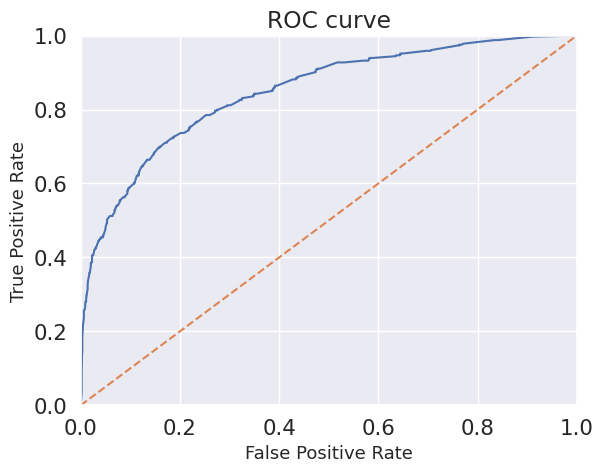

In [59]:
# Retrieve AUC-ROC metric
probabilities_test = model_rf1_final.predict_proba(features_ohe_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_ohe_test, probabilities_one_test)
print()
print('AUC_ROC score:', auc_roc)

# Plot curve
fpr, tpr, thresholds = roc_curve(target_ohe_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC curve')
plt.show()

# Conclusion

The fully optimized random forest model is the best model to predict if existing customers in Beta Bank are going to exit the bank or not. Given the <b>59%</b> F1 score of the model, this meets the threshold of <b>59%</b>, and Beta Bank should feel confident and comfortable that this model will help determine which members may leave the bank.